### Transforming the data for the performance spectrum

In [1]:
import pm4py
# read event logs with 
INPUT_FILENAME_BERLIN ='berlin-preprocessed-gesetzgebung-2006-2020.xes'
OUTPUT_FILENAME_BERLIN = 'berlin-preprocessed-gesetzgebung-2006-2020_mainBehavior.xes'
log_berlin = pm4py.read_xes(INPUT_FILENAME_BERLIN)
log_berlin = pm4py.convert_to_event_log(log_berlin)

INPUT_FILENAME_BAWUE = "baden-württemberg-preprocessed-gesetzgebung-gesetz-2006-2020_processed.xes"
OUTPUT_FILENAME_BAWUE = 'baden-württemberg-preprocessed-gesetzgebung-gesetz-2006-2020_processed_mainBehavior.xes'
log_bawue = pm4py.read_xes(INPUT_FILENAME_BAWUE)
log_bawue = pm4py.convert_to_event_log(log_bawue)


INPUT_FILENAME_BRANDENBURG = "brandenburg-preprocessed-gesetzgebung-2006-2020_processed.xes"
OUTPUT_FILENAME_BRANDENBURG = 'brandenburg-preprocessed-gesetzgebung-2006-2020_processed_mainBehavior.xes'
log_bran = pm4py.read_xes(INPUT_FILENAME_BRANDENBURG)
log_bran = pm4py.convert_to_event_log(log_bran)



coverage_perc_threshold = 0.8

/home/phillmann/.local/lib/python3.8/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/731 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1005 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/718 [00:00<?, ?it/s]

In [2]:
# get all activities that only occur once in a case
# and count them on the way

# remove traces that "don't make sense"
# that is traces with milestone activities occurring twice or more
def remove_weird_traces(log):
    # things that should not ever happen twice (logically) 

    dataframe = pm4py.convert_to_dataframe(log)
    countOfRemoved = 0 

    shouldNotsBerlin = ["I. Lesung" , "II. Lesung", "III. Lesung", "Bekanntmachung (Gesetz- und Verordnungsblatt)", "Gesetz- und Verordnungsblatt"]
    shouldNotsBran = ["Gesetzentwurf"]
    shouldNotsBaWue = ["Gesetzentwurf", "Erste Beratung", "Zweite Beratung", "Dritte Beratung", "Gesetz"]
    for trace in log:
        # collect all activity labels in the trace
        activityLabels = []
        for event in trace:
            activityLabels.append(event["concept:name"])

        for activityLabel in activityLabels:
            labelCount = activityLabels.count(activityLabel) 
            if labelCount >= 2 and (activityLabel in shouldNotsBerlin or activityLabel in shouldNotsBran or activityLabel in shouldNotsBaWue):
                #print("removing:", trace)
                dataframe = dataframe[dataframe["case:@@case_index"] != trace.attributes.get("@@case_index")]
                countOfRemoved += 1
                break

    print("removed", countOfRemoved, "traces")
    return pm4py.convert_to_event_log(dataframe)

def get_milestone_activities(log):

    milestone_activities = []
    non_milestone_activities = []

    for trace in log:

        # collect all activity labels in the trace
        activityLabels = []
        for event in trace:
            activityLabels.append(event["concept:name"])

        # check if milestone rule applies
        for activityLabel in activityLabels:
            labelCount = activityLabels.count(activityLabel)
            milestone_activities_labels = [x["activityLabel"] for x in milestone_activities]
            if labelCount == 1:
                if activityLabel in non_milestone_activities:
                    continue
                elif activityLabel not in milestone_activities_labels:
                    milestone_activities.append({"activityLabel": activityLabel, "count": 1})
                else:
                    for milestone in milestone_activities:
                        if milestone["activityLabel"] == activityLabel:
                            milestone["count"] += 1
            elif labelCount > 1:
                if activityLabel not in non_milestone_activities: 
                    non_milestone_activities.append(activityLabel)
                if activityLabel in milestone_activities_labels:
                    for milestone in milestone_activities:
                        if milestone["activityLabel"] == activityLabel:
                            milestone_activities.remove(milestone)
                    #print("REMOVING:", activityLabel)
                    #print("because of:")
                    #print(activityLabels)
                    
    return milestone_activities

def getTraceCount(log):
    return len(log)

#### 2. Identify milestone activities
* Rule: each milestone activity can occur only once in a case 
* and each milestone activity should be represented in almost all cases.

In [3]:
# define threshold for "almost all cases" here
threshold = 0.2

In [4]:
# get milestone activities according to only once rule

print (list)
## BERLIN
print("Milestone activities for Berlin:")
filteredLog_berlin = remove_weird_traces(log_berlin)
milestone_activities_berlin = get_milestone_activities(filteredLog_berlin)
for activity in milestone_activities_berlin:
    print("Activity: ", activity)

## BRANDENBURG
print("\nMilestone activities for Brandenburg:")
filteredLog_bran = remove_weird_traces(log_bran)
milestone_activities_bran = get_milestone_activities(filteredLog_bran)
for activity in milestone_activities_bran:
    print("Activity: ", activity)

## BAWÜ
print("\nMilestone activities for Baden-Württemberg:")
filteredLog_bawue = remove_weird_traces(log_bawue)
milestone_activities_bawue = get_milestone_activities(filteredLog_bawue)
for activity in milestone_activities_bawue:
    print("Activity: ", activity)

<class 'list'>
Milestone activities for Berlin:
removed 111 traces
Activity:  {'activityLabel': 'Vorlage zur Beschlussfassung (Gesetzentwurf)', 'count': 318}
Activity:  {'activityLabel': 'I. Lesung', 'count': 546}
Activity:  {'activityLabel': 'II. Lesung', 'count': 528}
Activity:  {'activityLabel': 'Gesetz- und Verordnungsblatt', 'count': 416}
Activity:  {'activityLabel': 'Antrag (Gesetzentwurf)', 'count': 228}
Activity:  {'activityLabel': 'Behandlung im Plenum', 'count': 26}
Activity:  {'activityLabel': 'Bekanntmachung (Gesetz- und Verordnungsblatt)', 'count': 59}
Activity:  {'activityLabel': 'Neufassung', 'count': 14}
Activity:  {'activityLabel': 'Ausschussbericht (Zwischenbericht)', 'count': 3}
Activity:  {'activityLabel': 'Vorlage zur Beschlussfassung', 'count': 1}
Activity:  {'activityLabel': 'III. Lesung', 'count': 1}

Milestone activities for Brandenburg:
removed 7 traces
Activity:  {'activityLabel': 'Gesetzentwurf', 'count': 563}
Activity:  {'activityLabel': '1. Lesung', 'count

In [5]:
# get milestone activites that are present in almost all cases (threshold)
# problem with this threshold is that for exmaple 'Antrag (Gesentzwurf)' and 'Vorlage zur Beschlussfassung (Gesetzentwurf)' 
# both only appear sometimes but could probably be aggregated as one activity 

## BERLIN
print("BERLIN:")
traceCount_berlin = getTraceCount(log_berlin)
print("original trace count: ", traceCount_berlin)
filtered_traceCount_berlin = getTraceCount(filteredLog_berlin)
print("filtered trace count: ", filtered_traceCount_berlin)
filtered_milestones_berlin = [x for x in milestone_activities_berlin if x["count"]/filtered_traceCount_berlin >= threshold]
print("filtered milestones:")
for activity in filtered_milestones_berlin:
    print("Activity: ", activity)

## BRANDENBURG
print("\n BRANDENBURG:")
traceCount_bran = getTraceCount(log_bran)
print("original trace count: ", traceCount_bran)
filtered_traceCount_bran = getTraceCount(filteredLog_bran)
print("filtered trace count: ", filtered_traceCount_bran)
filtered_milestones_bran = [x for x in milestone_activities_bran if x["count"]/filtered_traceCount_bran >= threshold]
print("filtered milestones:")
for activity in filtered_milestones_bran:
    print("Activity: ", activity)

## Baden-Württemberg
print("\n Baden-Württemberg:")
traceCount_bawue = getTraceCount(log_bawue)
print("original trace count: ", traceCount_bawue)
filtered_traceCount_bawue = getTraceCount(filteredLog_bawue)
print("filtered trace count: ", filtered_traceCount_bawue)
filtered_milestones_bawue = [x for x in milestone_activities_bawue if x["count"]/filtered_traceCount_bawue >= threshold]
print("filtered milestones:")
for activity in filtered_milestones_bawue:
    print("Activity: ", activity)



BERLIN:
original trace count:  731
filtered trace count:  620
filtered milestones:
Activity:  {'activityLabel': 'Vorlage zur Beschlussfassung (Gesetzentwurf)', 'count': 318}
Activity:  {'activityLabel': 'I. Lesung', 'count': 546}
Activity:  {'activityLabel': 'II. Lesung', 'count': 528}
Activity:  {'activityLabel': 'Gesetz- und Verordnungsblatt', 'count': 416}
Activity:  {'activityLabel': 'Antrag (Gesetzentwurf)', 'count': 228}

 BRANDENBURG:
original trace count:  718
filtered trace count:  711
filtered milestones:
Activity:  {'activityLabel': 'Gesetzentwurf', 'count': 563}
Activity:  {'activityLabel': '1. Lesung', 'count': 665}
Activity:  {'activityLabel': '2. Lesung', 'count': 445}
Activity:  {'activityLabel': 'Gesetz', 'count': 432}

 Baden-Württemberg:
original trace count:  1005
filtered trace count:  992
filtered milestones:
Activity:  {'activityLabel': 'Gesetzentwurf', 'count': 509}
Activity:  {'activityLabel': 'Erste Beratung', 'count': 371}
Activity:  {'activityLabel': 'Zweite

#### 3. Aggregating Multistep Milestone Activities
* not applicable here (at least not directly) 

#### 4. Validating Milestone Activities

In [6]:
print("BERLIN:")
efg = pm4py.discover_eventually_follows_graph(filteredLog_berlin, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
#print(efg)
for (efr) in efg:
    #print(efr, efg[efr])
    first, second = efr
    milestone_labels = [x["activityLabel"] for x in milestone_activities_berlin]
    if first in milestone_labels and second in milestone_labels:
        print(efr, ":", efg[efr])

print("\nBrandenburg:")
efg = pm4py.discover_eventually_follows_graph(filteredLog_bran, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
#print(efg)
for (efr) in efg:
    #print(efr, efg[efr])
    first, second = efr
    milestone_labels = [x["activityLabel"] for x in milestone_activities_bran]
    if first in milestone_labels and second in milestone_labels:
        print(efr, ":", efg[efr])

print("\nBaden-Württemberg:")
efg = pm4py.discover_eventually_follows_graph(filteredLog_bawue, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
#print(efg)
for (efr) in efg:
    #print(efr, efg[efr])
    first, second = efr
    milestone_labels = [x["activityLabel"] for x in milestone_activities_bawue]
    if first in milestone_labels and second in milestone_labels:
        print(efr, ":", efg[efr])



BERLIN:
('Vorlage zur Beschlussfassung (Gesetzentwurf)', 'I. Lesung') : 317
('Vorlage zur Beschlussfassung (Gesetzentwurf)', 'II. Lesung') : 314
('Vorlage zur Beschlussfassung (Gesetzentwurf)', 'Gesetz- und Verordnungsblatt') : 313
('I. Lesung', 'II. Lesung') : 528
('I. Lesung', 'Gesetz- und Verordnungsblatt') : 415
('II. Lesung', 'Gesetz- und Verordnungsblatt') : 415
('Antrag (Gesetzentwurf)', 'I. Lesung') : 227
('Antrag (Gesetzentwurf)', 'II. Lesung') : 213
('Antrag (Gesetzentwurf)', 'Gesetz- und Verordnungsblatt') : 101
('Vorlage zur Beschlussfassung (Gesetzentwurf)', 'Behandlung im Plenum') : 13
('Behandlung im Plenum', 'I. Lesung') : 1
('Behandlung im Plenum', 'II. Lesung') : 21
('Behandlung im Plenum', 'Gesetz- und Verordnungsblatt') : 13
('Antrag (Gesetzentwurf)', 'Behandlung im Plenum') : 13
('I. Lesung', 'Behandlung im Plenum') : 25
('I. Lesung', 'Antrag (Gesetzentwurf)') : 1
('Antrag (Gesetzentwurf)', 'Ausschussbericht (Zwischenbericht)') : 3
('I. Lesung', 'Ausschussbericht (

In [7]:
print("Berlin:")
efg = pm4py.discover_eventually_follows_graph(filteredLog_berlin, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
#print(efg)
for (efr) in efg:
    #print(efr, efg[efr])
    first, second = efr
    milestone_labels = [x["activityLabel"] for x in filtered_milestones_berlin]
    if first in milestone_labels and second in milestone_labels:
        print(efr, ":", efg[efr])

print("\nBrandenburg:")
efg = pm4py.discover_eventually_follows_graph(filteredLog_bran, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
#print(efg)
for (efr) in efg:
    #print(efr, efg[efr])
    first, second = efr
    milestone_labels = [x["activityLabel"] for x in filtered_milestones_bran]
    if first in milestone_labels and second in milestone_labels:
        print(efr, ":", efg[efr])

print("\nBaden-Württemberg:")
efg = pm4py.discover_eventually_follows_graph(filteredLog_bawue, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
#print(efg)
for (efr) in efg:
    #print(efr, efg[efr])
    first, second = efr
    milestone_labels = [x["activityLabel"] for x in filtered_milestones_bawue]
    if first in milestone_labels and second in milestone_labels:
        print(efr, ":", efg[efr])



Berlin:
('Vorlage zur Beschlussfassung (Gesetzentwurf)', 'I. Lesung') : 317
('Vorlage zur Beschlussfassung (Gesetzentwurf)', 'II. Lesung') : 314
('Vorlage zur Beschlussfassung (Gesetzentwurf)', 'Gesetz- und Verordnungsblatt') : 313
('I. Lesung', 'II. Lesung') : 528
('I. Lesung', 'Gesetz- und Verordnungsblatt') : 415
('II. Lesung', 'Gesetz- und Verordnungsblatt') : 415
('Antrag (Gesetzentwurf)', 'I. Lesung') : 227
('Antrag (Gesetzentwurf)', 'II. Lesung') : 213
('Antrag (Gesetzentwurf)', 'Gesetz- und Verordnungsblatt') : 101
('I. Lesung', 'Antrag (Gesetzentwurf)') : 1

Brandenburg:
('Gesetzentwurf', '1. Lesung') : 557
('Gesetzentwurf', '2. Lesung') : 445
('Gesetzentwurf', 'Gesetz') : 432
('1. Lesung', '2. Lesung') : 445
('1. Lesung', 'Gesetz') : 432
('2. Lesung', 'Gesetz') : 430

Baden-Württemberg:
('Gesetzentwurf', 'Erste Beratung') : 371
('Gesetzentwurf', 'Zweite Beratung') : 475
('Erste Beratung', 'Zweite Beratung') : 350
('Gesetzentwurf', 'Gesetzesbeschluss des Landtags') : 303
('Ges

#### 5. Extracting Main Behavior from Filtered Log
* identify most frequent case variants
* maybe get something like 80% of all behavior
* keep only cases of those variants

Berlin:
Number of variants: 115
Number of filtered cases: 620
No of main variants: 19
cases covered: 497
coverage percentage: 0.8016129032258065

So, the main behavior is described by those 24 variants!




exporting log, completed traces ::   0%|          | 0/497 [00:00<?, ?it/s]

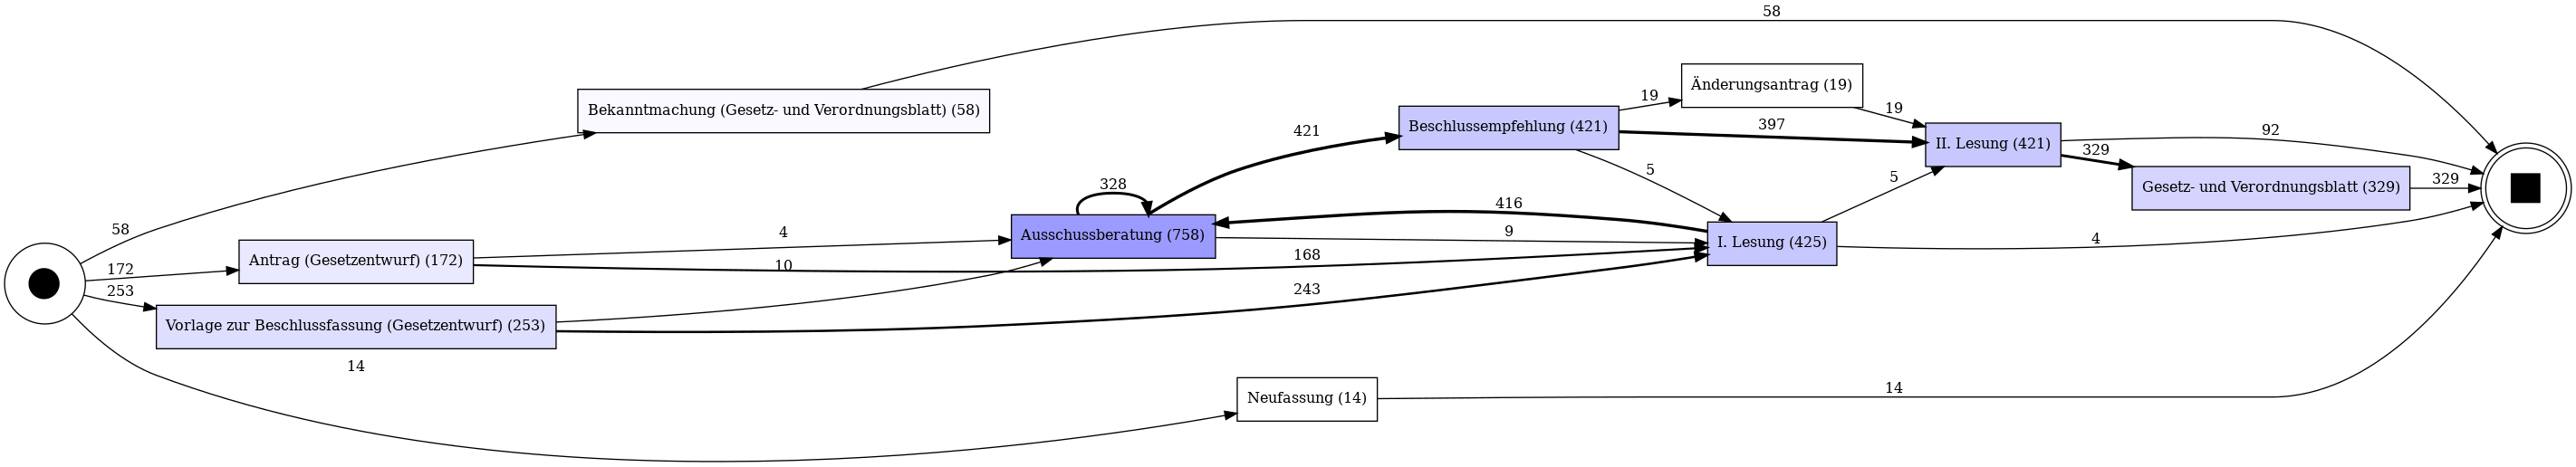

In [8]:
print("Berlin:")
variants = pm4py.get_variants(filteredLog_berlin)
#print(variants)
totalNoOfVariants = len(variants)
print("Number of variants:", totalNoOfVariants)
print("Number of filtered cases:", filtered_traceCount_berlin)

listOfVariants = variants.items()
#print(listOfVariants)
sorted_variants = sorted(listOfVariants, key=lambda item: len(item[1]), reverse=True)
#print(sorted_variants)

coveredCount = 0
mainVariants = []
coveragePerc = 0
for variant, list in sorted_variants:
    mainVariants.append(variant)
    coveredCount += len(list)
    coveragePerc = coveredCount/filtered_traceCount_berlin
    if coveragePerc >= coverage_perc_threshold:
        break

print("No of main variants:", len(mainVariants))
#for variant in mainVariants:
#    print(variant)

print("cases covered:", coveredCount)
print("coverage percentage:", coveragePerc)

print("\nSo, the main behavior is described by those 24 variants!")


mainBehavior_log = pm4py.filter_variants(filteredLog_berlin, mainVariants)
print("\n")
pm4py.write_xes(mainBehavior_log, OUTPUT_FILENAME_BERLIN)

dfg, start_activities, end_activities = pm4py.discover_dfg(mainBehavior_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

Brandenburg
Number of variants: 371
Number of filtered cases: 711
No of main variants: 229
cases covered: 569
coverage percentage: 0.8002812939521801

So, the main behavior is described by those variants!




exporting log, completed traces ::   0%|          | 0/569 [00:00<?, ?it/s]

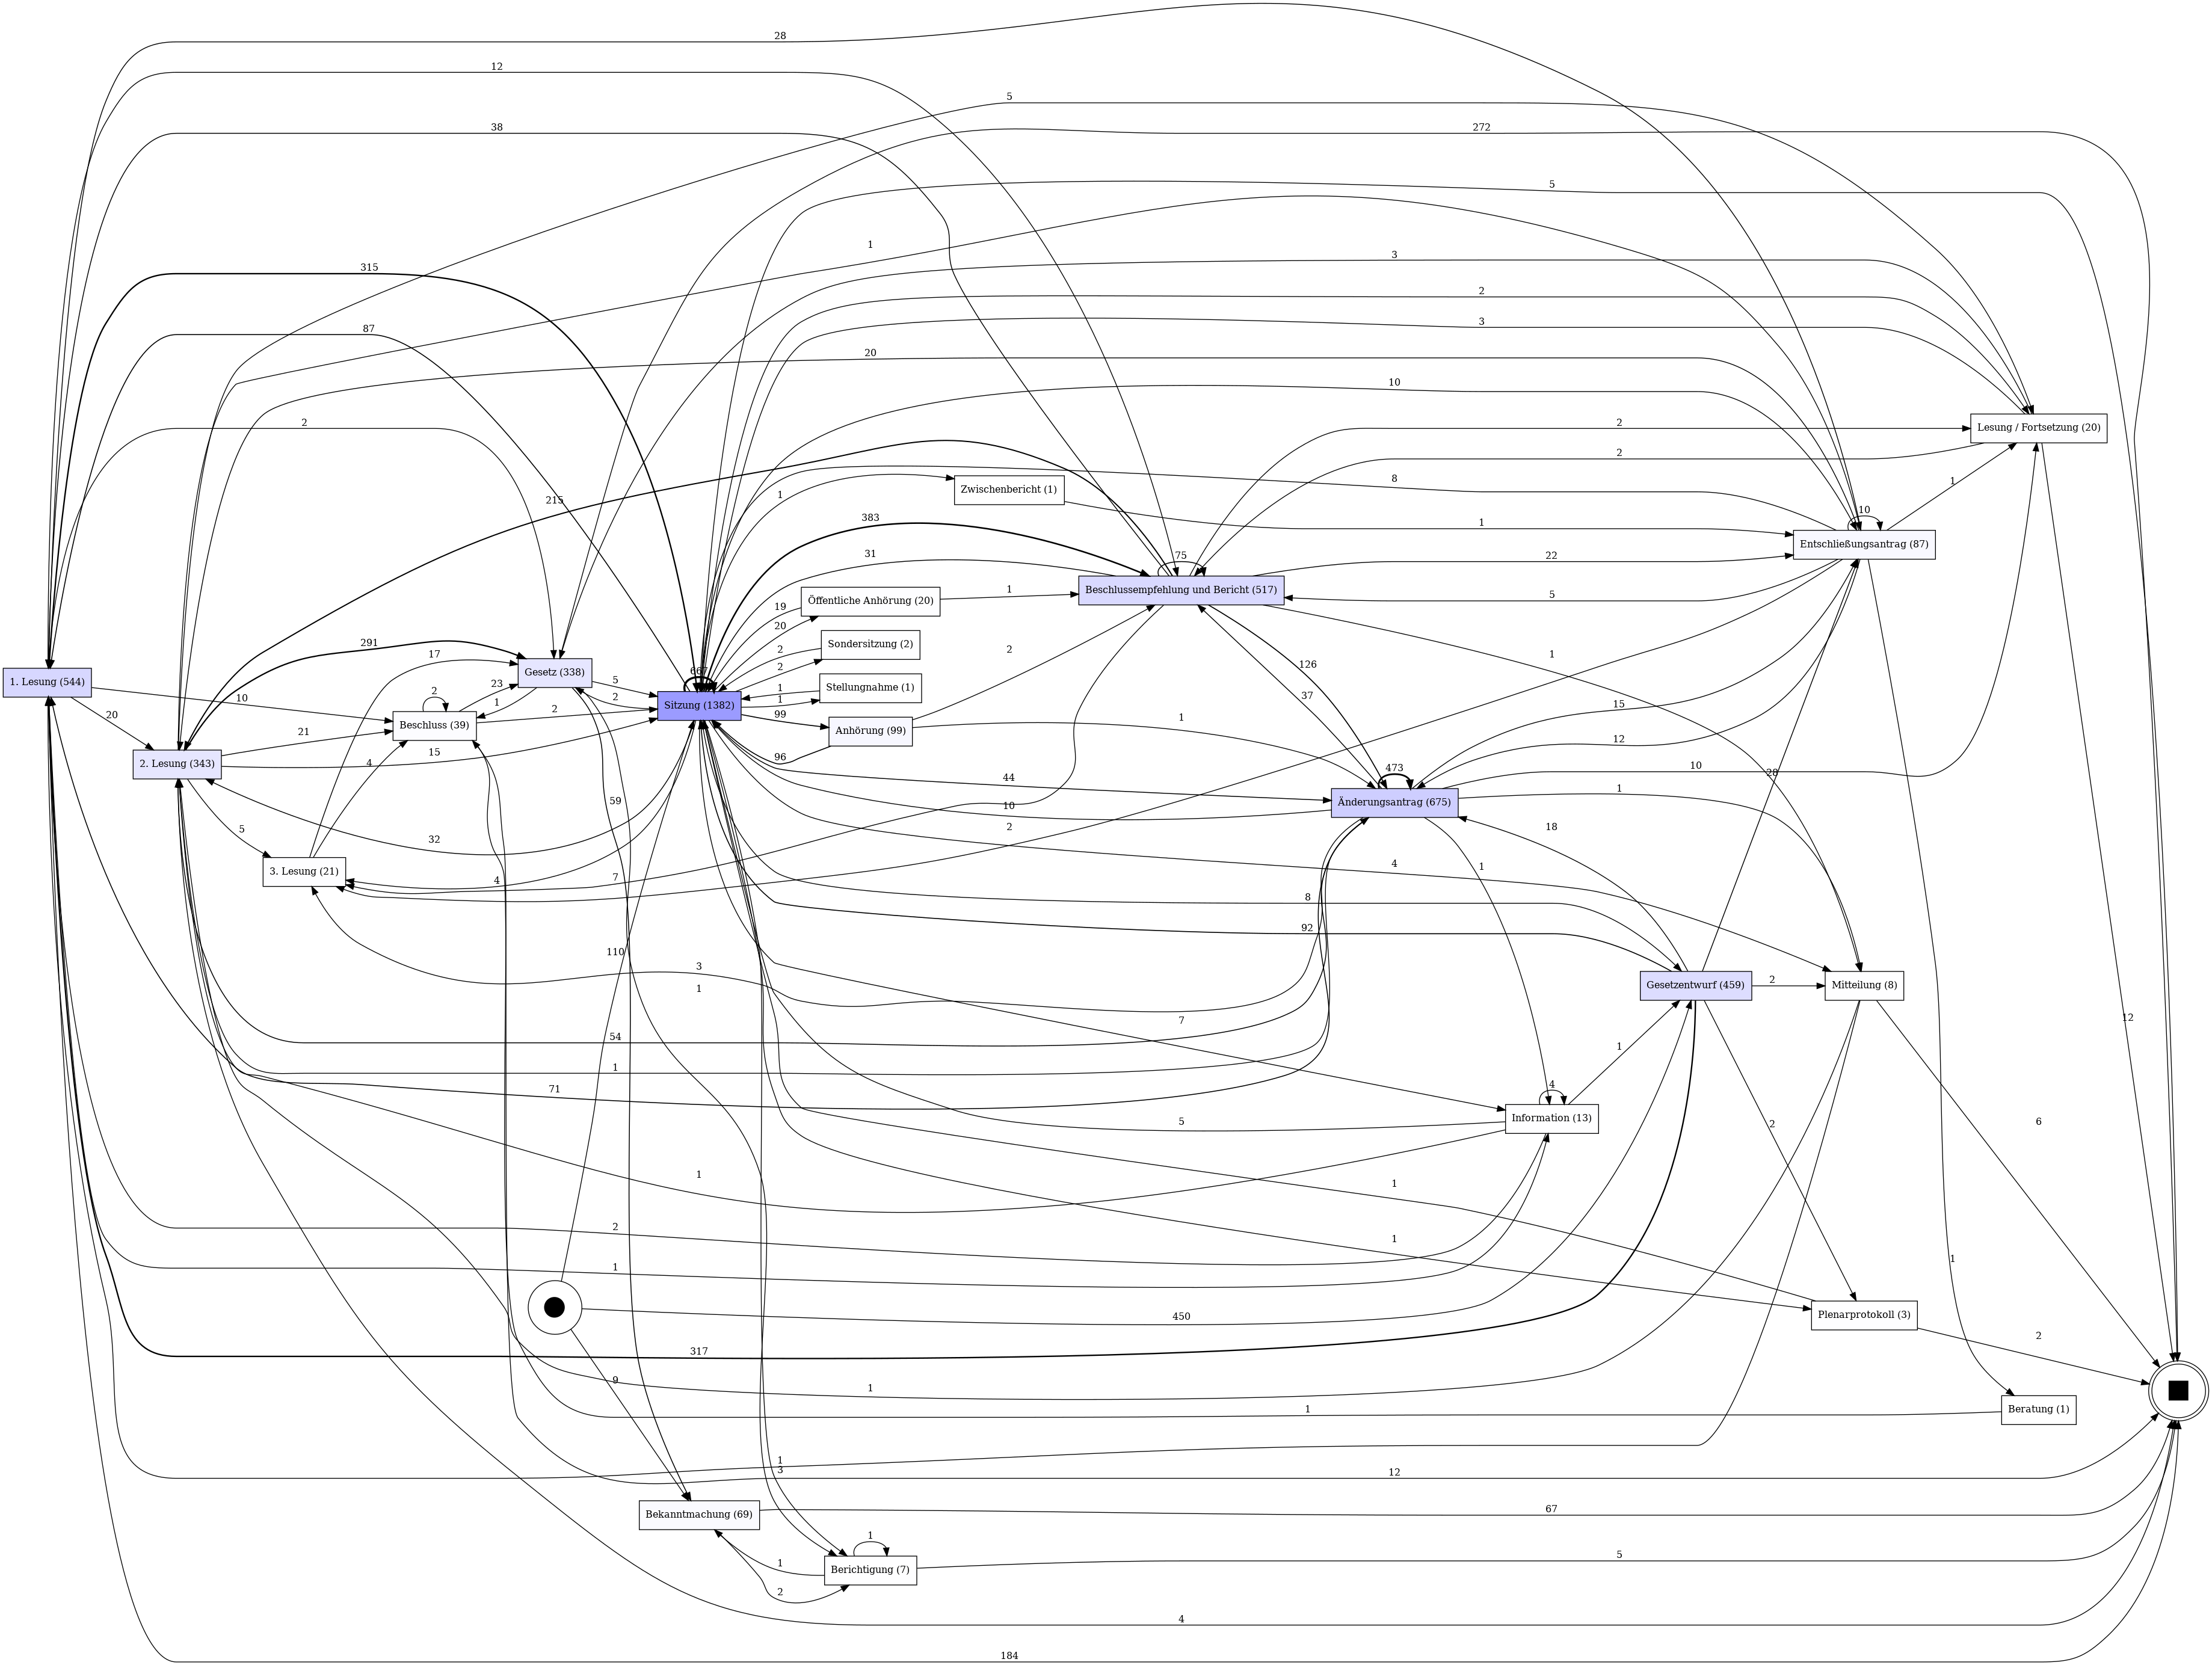

In [9]:
print("Brandenburg")
variants = pm4py.get_variants(filteredLog_bran)
#print(variants)
totalNoOfVariants = len(variants)
print("Number of variants:", totalNoOfVariants)
print("Number of filtered cases:", filtered_traceCount_bran)

listOfVariants = variants.items()

sorted_variants = sorted(listOfVariants, key=lambda item: len(item[1]), reverse=True)

coveredCount = 0
mainVariants = []
coveragePerc = 0
for variant, list in sorted_variants:
    mainVariants.append(variant)
    coveredCount += len(list)
    coveragePerc = coveredCount/filtered_traceCount_bran
    if coveragePerc >= coverage_perc_threshold:
        break

print("No of main variants:", len(mainVariants))
#for variant in mainVariants:
#    print(variant)

print("cases covered:", coveredCount)
print("coverage percentage:", coveragePerc)

print("\nSo, the main behavior is described by those variants!")


mainBehavior_log = pm4py.filter_variants(filteredLog_bran, mainVariants)
print("\n")
pm4py.write_xes(mainBehavior_log, OUTPUT_FILENAME_BRANDENBURG)

dfg, start_activities, end_activities = pm4py.discover_dfg(mainBehavior_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

BaWue:
Number of variants: 335
Number of filtered cases: 992
No of main variants: 137
cases covered: 794
coverage percentage: 0.8004032258064516

So, the main behavior is described by those variants!




exporting log, completed traces ::   0%|          | 0/794 [00:00<?, ?it/s]

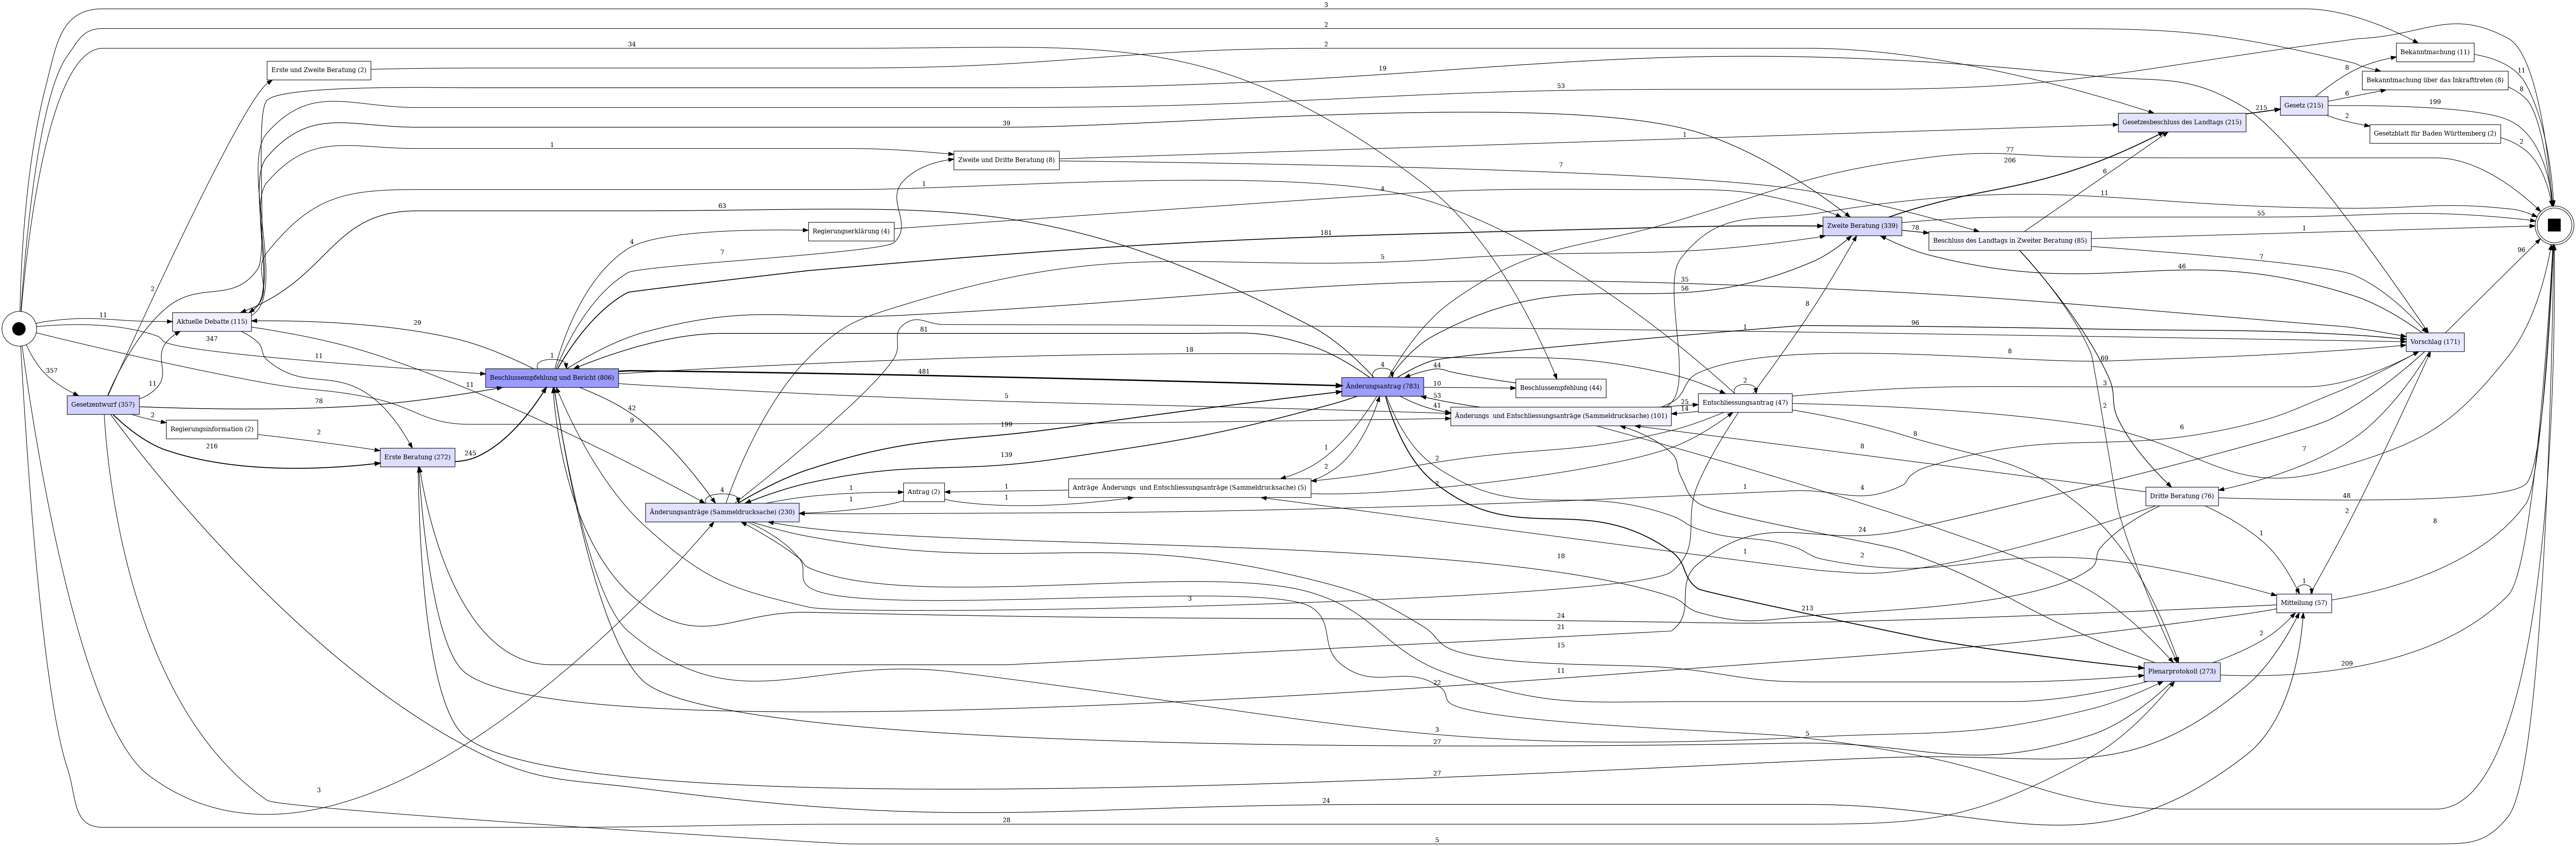

In [16]:
print("BaWue:")
variants = pm4py.get_variants(filteredLog_bawue)
#print(variants)
totalNoOfVariants = len(variants)
print("Number of variants:", totalNoOfVariants)
print("Number of filtered cases:", filtered_traceCount_bawue)

listOfVariants = variants.items()
#print(listOfVariants)
sorted_variants = sorted(listOfVariants, key=lambda item: len(item[1]), reverse=True)
#print(sorted_variants)

coveredCount = 0
mainVariants = []
coveragePerc = 0
for variant, list in sorted_variants:
    mainVariants.append(variant)
    coveredCount += len(list)
    coveragePerc = coveredCount/filtered_traceCount_bawue
    if coveragePerc >= coverage_perc_threshold:
        break

print("No of main variants:", len(mainVariants))
#for variant in mainVariants:
#    print(variant)

print("cases covered:", coveredCount)
print("coverage percentage:", coveragePerc)

print("\nSo, the main behavior is described by those variants!")


mainBehavior_log = pm4py.filter_variants(filteredLog_bawue, mainVariants)
print("\n")

# since proM performance spectrum miner does not like it "-" needs to be removed 
for trace in mainBehavior_log:
    for event in trace:
        if event['concept:name'].startswith(" "):
            event['concept:name'] = event['concept:name'].lstrip()
        if 'ß' in event['concept:name']:
            print(event['concept:name'])
            event['concept:name'] = event['concept:name'].replace('ß', 'ss')


pm4py.write_xes(mainBehavior_log, OUTPUT_FILENAME_BAWUE)

dfg, start_activities, end_activities = pm4py.discover_dfg(mainBehavior_log)
pm4py.view_dfg(dfg, start_activities, end_activities)